# Project: NIP
# Subroject: Sylhet Floods NASA IMPACT Sentinel-1 machine learning inference
## Script: scale_chip_s1_RTCScenes.ipynb
This script prepares the Sentinel-1 data into chips for running the NASA IMPACT machine learning inference. We follow the same steps used by NASA IMPACT when they created the original data for the training of the ML models.

This assumes that radiometric-terrain corrected images have already been acquired using the Hybrid Pluggable Processing Pipeline or ”HyP3” system, from the Alaska Satellite Facility (https://hyp3-docs.asf.alaska.edu/using/sdk/).

We then convert to WGS 84 (EPSG:4326), and convert the images into a uint8 data from uint16.

Then, we chip the images into 256x256 pixels of 10 m resolution and save tiffs.

In [1]:
import ee

In [2]:
ee.Authenticate()

Enter verification code:  4/1AVHEtk5RZtwV356HmbLD8yRFr8ybG5nJP8m-q4V2t41-v0UJrTpBflnbW6w



Successfully saved authorization token.


In [3]:
ee.Initialize()

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import geemap
import importlib
import shutil
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import warp
import zipfile
import geopandas as gpd
from osgeo import gdal
import json
from py_linq import Enumerable
from shapely.geometry import box
from shapely.geometry import Polygon
from osgeo import gdal
import fiona
from osgeo import gdal, ogr

In [2]:
# Set the root path
rootPath = Path('Z:/media/mule/Projects/NASA/NIP/Data/Raster/')

In [3]:
# Set the module path for accessing the Devries scripts
module_path = os.path.abspath(os.path.join('C:/Users/alexsaunders/Documents/01_uoa/04_git/NIP/SylhetNASAImpact/'))
# module_path = os.path.abspath(os.path.join('C:/Users/alexa/Documents/GitHub/NIP/SylhetNASAImpact/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Import modules from the helpers folder
import Helpers.prepare_chips as prepChips
importlib.reload(prepChips)

<module 'Helpers.prepare_chips' from 'C:\\Users\\alexsaunders\\Documents\\01_uoa\\04_git\\NIP\\SylhetNASAImpact\\Helpers\\prepare_chips.py'>

## PART 1: Convert the images from UTM to WGS 84 (EPSG:4326) and crop to the ROI
Crop to the ROI here to save processing time in the remainder

### Creating ROI bounds shapefile for cropping the full rasters

In [5]:
# Read the geojson of the ROI
sylhet_dist_geojson = gpd.read_file(Path('Z:/media/mule/Projects/NASA/NIP/Data/Geojson')/'sylhet_dist.geojson')

# Define the coordinates of the bounding box for the ROI
bounds = sylhet_dist_geojson.geometry.unary_union.bounds
coords = [(bounds[0], bounds[1]),
          (bounds[2], bounds[1]),
          (bounds[2], bounds[3]),
          (bounds[0], bounds[3])]

# Create a Shapely polygon from the coordinates
roiBounds = Polygon(coords)

In [31]:
# Write shapeply polygon to a shapefile that gdal warp can use for cropping
schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}

# Define the output shapefile
roiBoundsShapefile = 'Z:/media/mule/Projects/NASA/NIP/Data/Shapefiles/SylhetDistBbox/SylhetDistBbox.shp'

# Open the output shapefile for writing
with fiona.open(roiBoundsShapefile, 'w', 'ESRI Shapefile', schema) as output:

    # Create a feature from the shapely polygon and add it to the shapefile
    feature = {'geometry': roiBounds.__geo_interface__, 'properties': {'id': 1}}
    output.write(feature)

In [6]:
# Define the output shapefile
roiBoundsShapefile = 'Z:/media/mule/Projects/NASA/NIP/Data/Shapefiles/SylhetDistBbox/SylhetDistBbox.shp'

### Reprojecting and cropping

In [7]:
# Define input path for RTC files
rtcPath = rootPath/'SylhetNASAImpact/1_RTC'

In [8]:
# Define the output path for saving the WGS84 files
WGS84Path = rootPath/'SylhetNASAImpact/2_WGS84Cropped_V2'
WGS84Path.mkdir(exist_ok=True)
target_crs='EPSG:4326'#'epsg:4326'

In [23]:
# Loop through each of the original RTC rasters (in this case, one for each date)
rtcZips = list(rtcPath.iterdir())

for rtcZip in rtcZips:
    
    with zipfile.ZipFile(str(rtcZip), 'r') as rtcZipOpen:

        # Get the names of the VV and VH tif files
        rtcList = [item for item in rtcZipOpen.namelist() if item[-6:] == 'VH.tif' or item[-6:] == 'VV.tif']

        # Loop through VH and VV files
        for rtc in rtcList:

            # Get the date from the filename
            date = rtc[7:15]
            polar = rtc[-6:-4]
            rtcWGS84File = WGS84Path/('_'.join(rtc.split('/')[1].split('_')[0:3])+'_WGS84Cropped_'+str(polar)+'.tif')
            print('Creating file:', rtcWGS84File)
            
            # Check if file already exists in whichh case skip ****
            if os.path.exists(rtcWGS84File):
                continue
            
            # Open the raster file and reproject tif files from native CRS to WGS84
            rtcFile='/vsizip/'+str(rtcZip)+'/'+str(rtc)
            rtcRaster = gdal.Open(rtcFile)
            warp = gdal.Warp(str(rtcWGS84File), 
                             rtcRaster, 
                             dstSRS=target_crs,
                             cutlineDSName=roiBoundsShapefile,
                             cropToCutline=True,
                             dstNodata = -3.4028234663852886e+38) # 0, THIS BIT COULD BE WRONG?
            warp = None

Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220501T234740_WGS84Cropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220501T234740_WGS84Cropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220511T115642_WGS84Cropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220511T115642_WGS84Cropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220513T234740_WGS84Cropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220513T234740_WGS84Cropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\2_WGS84Cropped_V2\S1A_IW_20220523T115643_WGS84Cropped_VV.tif
Creating file: Z:\media\mule\Projects\NAS

## PART 2: Convert to uint8 and apply the VV and VH scaling

In [9]:
# Define the output path for saving the scaled files
ScaledPath = rootPath/'SylhetNASAImpact/3_Scaled_V2'
ScaledPath.mkdir(exist_ok=True)

In [10]:
# Define the scaling values - using the same as used by NASA IMPACT to create original data for competiton for ML trainning
scalingVals = {'vhMin': -30, 'vhMax': -10,
              'vvMin': -20, 'vvMax': 0}

In [11]:
# Function to bytescale - since scipy bytescale is deprecated
def bytescaling(data, cmin=None, cmax=None, high=255, low=0):
    """
    Converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255). If the input image already has 
    dtype uint8, no scaling is done.
    :param data: 16-bit image data array
    :param cmin: bias scaling of small values (def: data.min())
    :param cmax: bias scaling of large values (def: data.max())
    :param high: scale max value to high. (def: 255)
    :param low: scale min value to low. (def: 0)
    :return: 8-bit image data array
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        high = 255
    if low < 0:
        low = 0
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

In [27]:
# Loop through the WGS84 raster on each date
WGS84Files = list(WGS84Path.iterdir())

for WGS84File in WGS84Files:
    
    # Get the date and polarization from the filename
    date = str(WGS84File)[-28:-20]
    polar = str(WGS84File)[-6:-4]
    ScaledFile = ScaledPath/(WGS84File.stem.replace('WGS84','WGS84Scaled')+WGS84File.suffix)
    print('Creating file:', ScaledFile)

    # Check if file already exists in whichh case skip ****
    if os.path.exists(ScaledFile):
        continue

    # Open the raster file
    with rio.open(WGS84File) as raster_in:
        
        # Get the raster metadata and read raster to array
        profile = raster_in.profile
        rasterArray = raster_in.read()

        # Convert to uint8 with the defined scaling
        if (polar == 'VH'):
            rasterScaled = bytescaling(rasterArray, cmin=scalingVals['vhMin'], cmax=scalingVals['vhMax'])
        if (polar == 'VV'):
            rasterScaled = bytescaling(rasterArray, cmin=scalingVals['vvMin'], cmax=scalingVals['vvMax'])
            
        # Get back into 2D
        rasterScaled = rasterScaled[0]
        
        # Update the profile metadata
        profile.update(dtype=rio.uint8, nodata=0)

        # Write out as tiff
        with rio.open(ScaledFile, 'w', **profile) as raster_out:
            raster_out.write(rasterScaled, 1) 

Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220501T234740_WGS84ScaledCropped_VH.tif


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_14852\1653599526.py:34: RuntimeWarning: overflow encountered in multiply
  bytedata = (data - cmin) * scale + low


Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220501T234740_WGS84ScaledCropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220511T115642_WGS84ScaledCropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220511T115642_WGS84ScaledCropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220513T234740_WGS84ScaledCropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220513T234740_WGS84ScaledCropped_VV.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220523T115643_WGS84ScaledCropped_VH.tif
Creating file: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\3_Scaled_V2\S1A_IW_20220523T115643_WGS84ScaledCropped_VV.tif
Creating file: Z:\media\mule\Projects\NAS

## PART 3: Chip the S-1 images
Create a grid for the provided ROI and chip the images to 256x256 pixels. Note that we have a single S1 image for each date (i.e., do not need to stitch multiple scenes before tiling).

In [12]:
# Create the output folder for saving the chips
TilesPath = rootPath/'SylhetNASAImpact/4_Tiles_V2'
TilesPath.mkdir(exist_ok=True)

In [13]:
# Define desired tile dimensions
tileWidth = 256
tileHeight = 256

# Loop through the RTC WGS84 Scaled raster files on each date
ScaledFiles = list(ScaledPath.iterdir())

for ScaledFile in ScaledFiles:
    
    # Get the date and polarization from the filename, create new folder to saving chips for given date
    date = ScaledFile.stem[7:15]
    polar = ScaledFile.stem[-2:]
    TilesDatePath = TilesPath/date
    TilesDatePath.mkdir(exist_ok=True)
    print('Creating tiles for:', TilesDatePath)

    # Chip the raster into 256x256 pixels
    r = gdal.Open(str(ScaledFile))

    width = r.RasterXSize
    height = r.RasterYSize

    count_i = 0
    count_j = 0

    # Loop through width and height increments to chip up the full raster
    for i in range(0, width, tileWidth):
        for j in range(0, height, tileHeight):

            # Check if already exists in which case skip to the next 
            TileName = str(TilesDatePath) + "/" + str(date) + "_" + str(count_i) + "_" + str(count_j) + "_" + str(polar) + ".tif"
            if os.path.exists(TileName):
                continue

            print(f"processing file {TileName}", end='\r')
            gdal.Translate(TileName, r, srcWin=[i, j, tileWidth, tileHeight])
            count_j = count_j + 1

        count_i = count_i + 1
        count_j = 0

    r = None

Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220501
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220501
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220511
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220511
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220513
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220513
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220523
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220523
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2\20220525
Creating tiles for: Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\4_Tiles_V2

### Drop tiles that do not intersect with the ROI and have zero data - NOT USED

In [16]:
# Helper functions
Path.ls = lambda x: list(x.iterdir())
Path.lsTif = lambda x: Enumerable(x.iterdir()).where(lambda p: p.suffix == '.tif').to_list()

In [17]:
# Function to create dataframe of bounding 
def createBoundsShapefileDF(inDir, fileList=None):
    dfScenes = gpd.GeoDataFrame(columns=['location','geometry'])
    if fileList == None:
        fileList = inDir.lsTif()
    else:
        fileList = [inDir/file for file in fileList]
    nbFiles = len(fileList)
    for i, filePath in enumerate(fileList):
        print(f"processing file {i+1}/{nbFiles}", end='\r')
        strFilePath = str(filePath)
        bounds = rio.open(strFilePath).bounds
        dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
    dfScenes = dfScenes.set_crs("EPSG:4326")
    return dfScenes

In [ ]:
# Loop through folders containing chips on each date, create new date folder for each to save the valid tiles
TilesDatePaths = list(TilesPath.iterdir())

ViableTilesPath = rootPath/'SylhetNASAImpact/5_ViableTiles'
ViableTilesPath.mkdir(exist_ok=True)

for TilesDatePath in TilesDatePaths:

    # Create separate folder for saving valid tiles
    date = TilesDatePath.stem
    ViableTilesDatePath = ViableTilesPath/date
    ViableTilesDatePath.mkdir(exist_ok=True)
    ViableTilesDatePathStr = str(ViableTilesDatePath)
    
    # Select chips which intersect the Sylhet District ROI
    TilesBounds = createBoundsShapefileDF(TilesDatePath)
    TilesContainingROI = TilesBounds[TilesBounds.geometry.intersects(roiBounds)].location
    validTiles = list(set(TilesContainingROI))

    # Select chips which have all non-zero data (i.e., full tile has data)
    completeTiles = list()
    ss = np.zeros(len(validTiles))

    for i, tile in enumerate(validTiles):
        print(f"processing file {i+1}/{len(validTiles)}", end='\r')
        r = rio.open(tile)
        s = np.sum(r.read(1).flatten() == r.nodata)
        ss[i] = s
        if(s == 0):
            completeTiles.append(tile)
    # plt.hist(ss)
    r.close()
    print('Started with total of {0} chips, to {1} chips which intersect the ROI, to {2} chips which contain data across the whole chip'.format(len(df), len(validTiles), len(completeTiles)))
    
    # Write json of the complete chips
    (TilesDatePath/"completeTileList.json").write_text(json.dumps(completeTiles))

    # Copy valid tiles to folder
    for i, tile in enumerate(completeTiles):
        if os.path.exists(ViableTilesDatePathStr+'\\'+(tile.split('\\')[-1])):
            continue
        else:
            shutil.copy(tile, ViableTilesDatePathStr)
        print('Copied chip', i+1, 'of', len(completeTiles), end='\r')

## PART 4: Visualize the extent of the tiles

In [17]:
tilesPath = Path('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/5_ViableTiles/20220501')
tilesFiles = list(tilesPath.iterdir())

vv_files = [str(file).split('\\')[-1] for file in tilesFiles if 'VV.tif' in str(file)]
vh_files = [str(file).split('\\')[-1] for file in tilesFiles if 'VH.tif' in str(file)]


In [19]:
vv_files_bounds = createBoundsShapefileDF(tilesPath, fileList=vv_files)
vh_files_bounds = createBoundsShapefileDF(tilesPath, fileList=vh_files)

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

processing file 799/933

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13448\724766185.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfScenes = dfScenes.append({'location':strFilePath, 'geometry': box(bounds[0], bounds[1], bounds[2], bounds[3])},ignore_index=True)


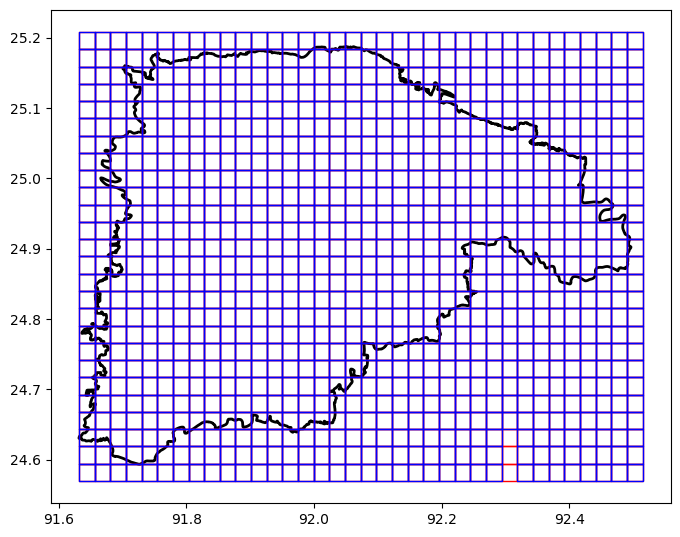

In [38]:
# Create plot - use a gray colormap just to 
fig, ax = plt.subplots(figsize=(8, 8))

# Add the Sylhet District outline
sylhet_dist.boundary.plot(ax=ax, color = 'black', linewidth=2, label='Sylhet District', zorder=3)
vh_files_bounds.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='VV', zorder=4)
vv_files_bounds.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1, label='VH', zorder=4)

plt.show()